# TCLAB_CLP_PID_FF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import colors as mcolors
import pandas as pd

from datetime import datetime
import tclab
import time

import os

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import *

# Controller and FF parameters

In [2]:
TSim = 3000
Ts = 1
N = int(TSim/Ts + 1) 

#working point
MV0 = 50
DV0 = 50
PV0 = 65.11

#process
#-------
#parameters for input-output dynamics
Kp = 0.45114207269109724
T1p = 110.89766441155744
T2p = 20.20409707770138
thetap = 11.421940328176037

#parameters for disturbance dynamics
Kd = 0.39493489030424944
T1d = 176.54512623159854
T2d = 35.063342202231915
thetad = 14.280806053306666

#tuning of controller
gamma = 0.6
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma)

alpha = 1

MVMin = 0
MVMax = 100

# Input signals

In [3]:
## scenario 1: OLP + no FF
ManPath = {0: True, TSim: True}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, TSim: PV0}
DVPath = {0: 50, 1300: 60, TSim: 60.0}
ActivateFF = False
ManFF = True

## scenario 2: OLP + FF
#ManPath = {0: True, TSim: True} 
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0, TSim: PV0}
#DVPath = {0: 50.0, 1300: 60, TSim: 60.0}
#ActivateFF = True
#ManFF = True

## scenario 3: CLP + no FF
#ManPath = {0: True, 500: False, TSim: False} 
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0+5, 1800: PV0-5, TSim: PV0-5}
#DVPath = {0: DV0, 2100: DV0+10, TSim: DV0+10}
#ActivateFF = False
#ManFF = False

## scenario 4: CLP + FF
#ManPath = {0: True, 500: False, TSim: False}
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0+5, 1800: PV0-5, TSim: PV0-5}
#DVPath = {0: DV0, 2100: DV0+10, TSim: DV0+10}
#ActivateFF = True
#ManFF = False

# Real-time control and visualisation of the signals

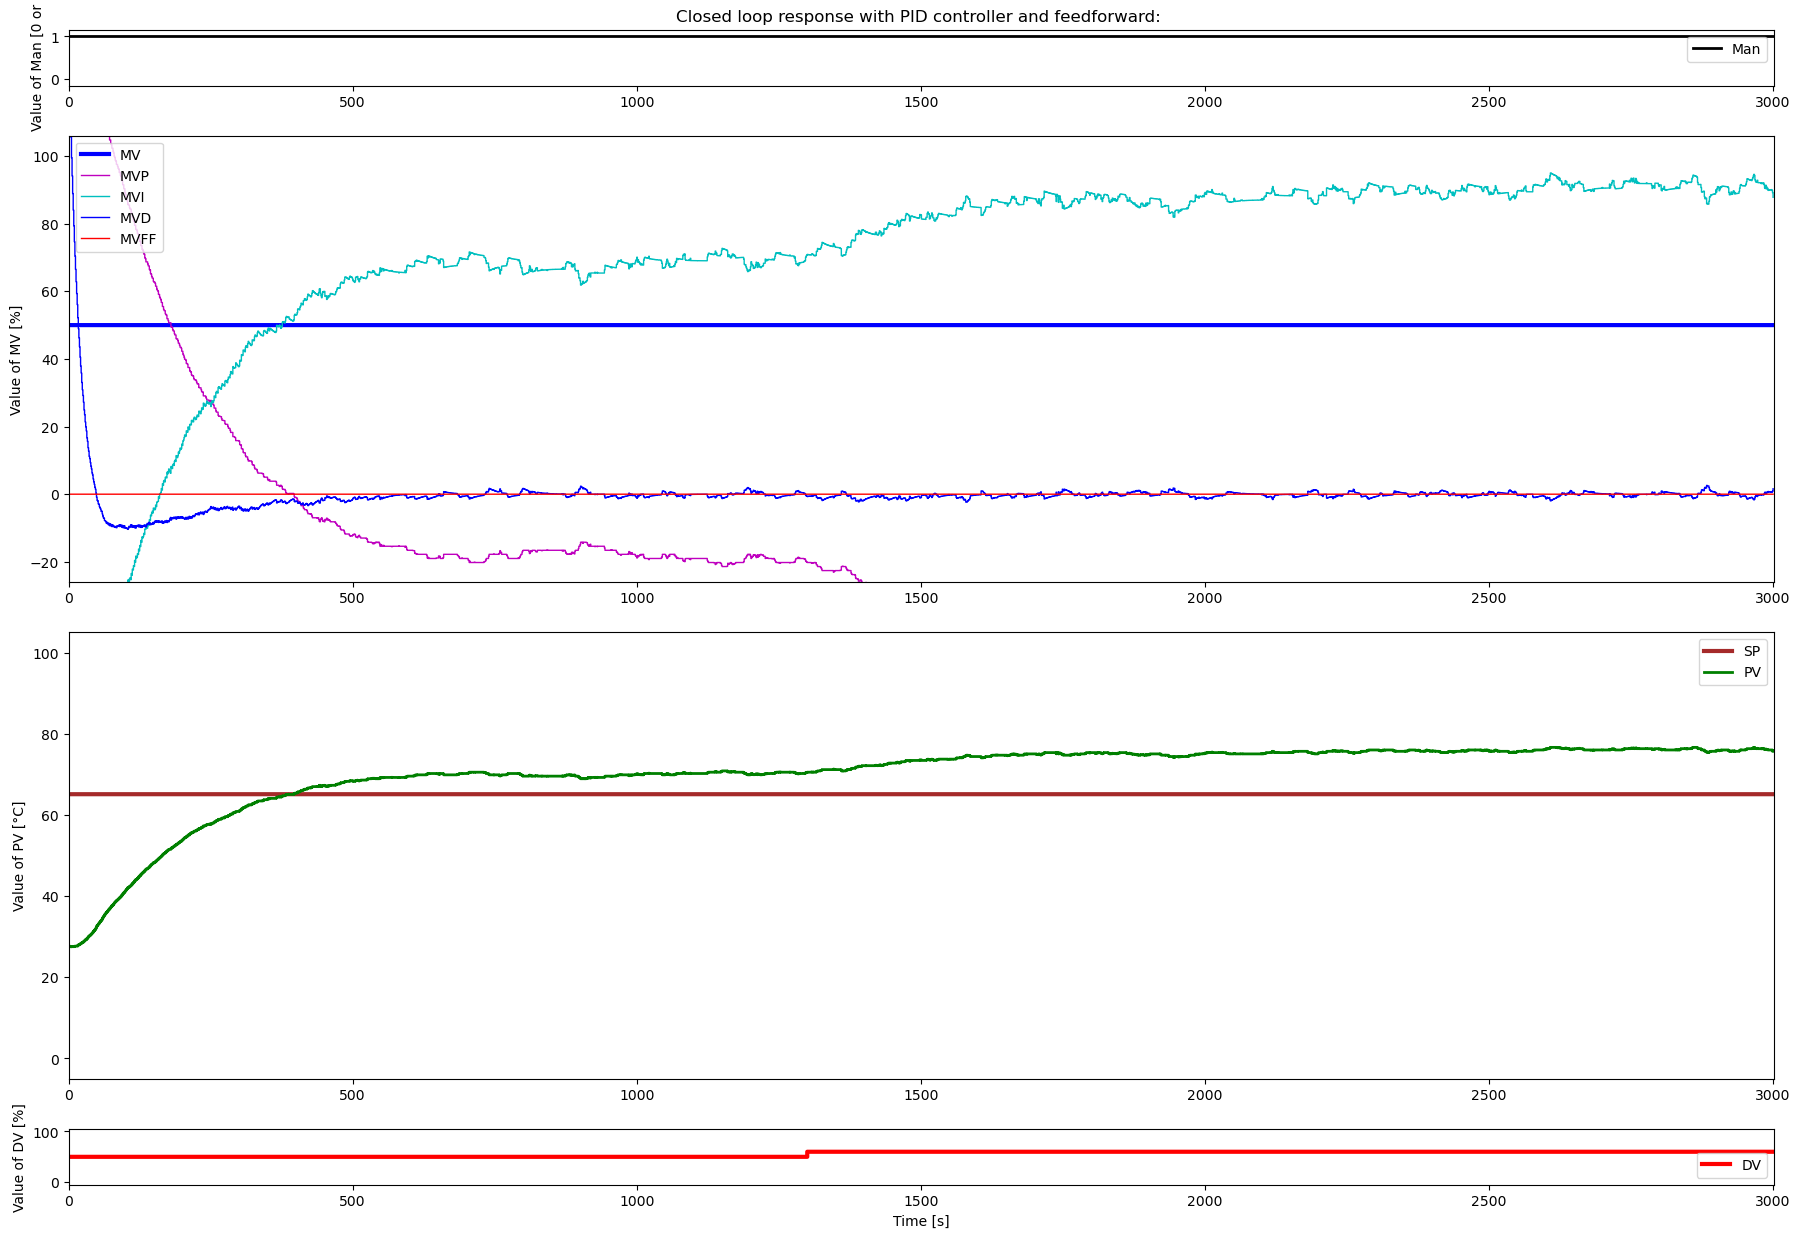

TCLab disconnected successfully.


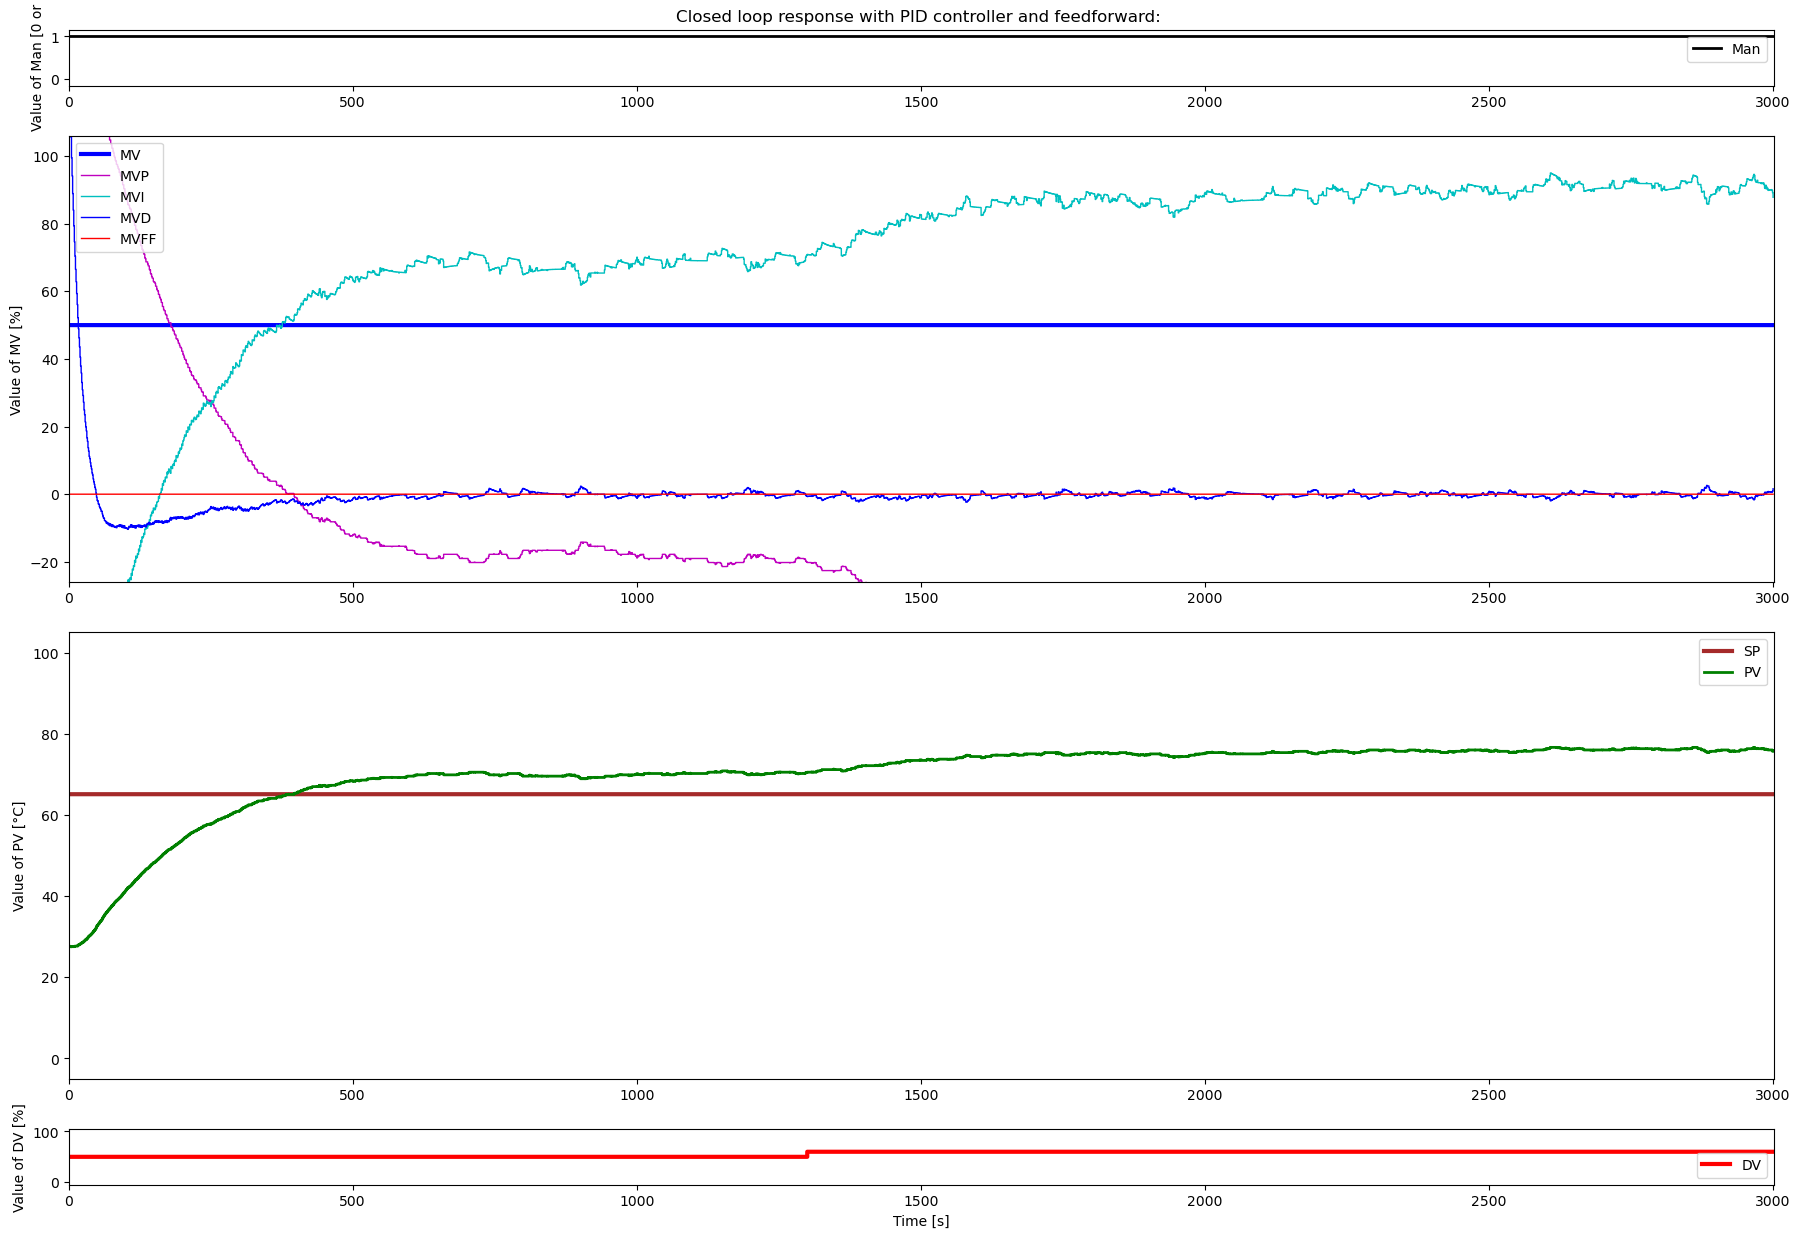

In [4]:
t = [] 
SP = []
PV = []
Man = []
MVMan = []
MVFF = []
MV = []
MVP = []
MVI = []
MVD = []
DV = []
E = []

MVFFDelay = []
MVFFLL1 = []

lab = tclab.TCLab()

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios':[1,8,8,1]}) 
fig.set_figheight(15)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[-0.1,1.1],'k-', linewidth=2, label='Man', where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed loop response with PID controller and feedforward: ')
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[-20,100],'b-', linewidth=3, label='MV', where='post')
l3, = ax2.step([0,TSim],[-20,100],'m-', linewidth=1, label='MVP', where='post')
l4, = ax2.step([0,TSim],[-20,100],'c-', linewidth=1, label='MVI', where='post')
l5, = ax2.step([0,TSim],[-20,100],'b-', linewidth=1, label='MVD', where='post')
l6, = ax2.step([0,TSim],[-20,100],'r-', linewidth=1, label='MVFF', where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l7, = ax3.step([0,TSim],[0,100],'brown', linewidth=3, label='SP', where='post')
l8, = ax3.step([0,TSim],[0,100],'g-', linewidth=2, label='PV', where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

l9, = ax4.step([0,TSim],[0,100],'r-', linewidth=3, label='DV', where='post')
ax4.set_ylabel('Value of DV [%]')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')

for i in range(0,N):
    t.append(i*Ts)

    if t[-1] == 0:
        last_time = time.time()
        
    PV.append(lab.T1)   
    
    #Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    lab.Q2(DV[-1])

    #Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad - thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else:
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

    #PID Controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    #PID Controller action
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)
        
    lab.Q1(MV[-1])

    now = time.time()
    delta = now - last_time

    l1.set_data(t,Man)

    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,MVFF)

    l7.set_data(t,SP)
    l8.set_data(t,PV)

    l9.set_data(t,DV)

    clear_output(wait=True)    
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    display(fig)

lab.close()

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t =  np.array(t) 
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
PV = np.array(PV)
DV = np.array(DV) 
SP = np.array(SP)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,PV.T,DV.T,SP.T,Man.T))
my_data = my_data.T
nameFile = 'Data/RT_test_on_' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,PV,DV,SP,Man',comments='')        


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'RT_test_on_NoFF_Auto' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)  